In [1]:
# import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import findspark
import numpy as np
import datetime as dt

from datetime import datetime, timedelta, date
### This program requires a local installation of APACHE SPARK to run

# Start Spark Session
findspark.init('C:\Spark\spark-3.2.2-bin-hadoop2.7')
import pyspark
from pyspark import SparkFiles
from pyspark.sql.functions import to_date, to_timestamp
from getpass import getpass


# Build Spark Session
### IMPORTANT: MAKE SURE THAT spark.config has memory set to 16GB or larger!
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Qwest-Analytics-Dashboard-and-ML-Model").config("spark.jars", "C:\Spark\spark-3.2.2-bin-hadoop2.7\jars\postgresql-42.5.0.jar").getOrCreate()

In [2]:
### THIS IS THE FINAL DATABASE PULL, DO NOT RUN UNTIL OPTIMIZATIONS AND DATA CLEANING HAVE FINISHED ###

# Connecting to database and exporting data

#Store environmental variables
password = getpass('Enter DataBase Password: ')

#Configure for RDS
jdbc_url="jdbc:postgresql://qwest-final-project.ccngkdwtiuvz.us-east-2.rds.amazonaws.com:5432/Qwest-Database"
config = {"user":"postgres", 
          "password": password, 
          "driver":"org.postgresql.Driver"}

# Load the ProgrammaticData.csv which contains features and fill rate
programmatic_data = spark.read.format("jdbc").options(
         url='jdbc:postgresql://qwest-final-project.ccngkdwtiuvz.us-east-2.rds.amazonaws.com:5432/Qwest-Database',
         dbtable='cleaned_advertising_data',
         user='postgres',
         password=password,
         driver='org.postgresql.Driver').load()

programmatic_data.show()
programmatic_data.printSchema()

+----------+--------------+-------------+--------+-----------+-------------+-----------------+------------+-------------+--------+-----------+-------+------------------+----------------------+----------------------+-------------------+--------------------+----------------------+
|      date|       country|       region|operator|    channel|pod_fill_rate|endpoint_requests|bid_requests|bid_responses|bid_wons|impressions|revenue|               cpm|requested_pod_duration|requested_pod_droprate|filled_pod_duration| filled_pod_droprate|delivered_pod_duration|
+----------+--------------+-------------+--------+-----------+-------------+-----------------+------------+-------------+--------+-----------+-------+------------------+----------------------+----------------------+-------------------+--------------------+----------------------+
|2022-08-23|        Mexico|North America|  Op_002|Channel_002|         0.15|             8268|      714194|        63542|   14936|       6268|  25.16| 4.0140395

In [3]:
### PROVISONAL DATABASE ONLY.  DELETE IN FINAL VERSION.  FOR TESTING ONLY ###
# programmatic_data = pd.read_csv('Resources/Clean_Advertising_Data_v4.csv')
# programmatic_data_df = pd.DataFrame(programmatic_data)

In [4]:
# In order to convert date to an integer or float, we need to determine how many days from some given day for the data we want to collect.
programmatic_data_df = programmatic_data.toPandas()
programmatic_data_df['date'] = pd.to_datetime(programmatic_data_df['date'])
programmatic_data_df = programmatic_data_df.sort_values(by='date', ascending=True)
programmatic_data_df

,date,country,region,operator,channel,pod_fill_rate,endpoint_requests,bid_requests,bid_responses,bid_wons,impressions,revenue,cpm,requested_pod_duration,requested_pod_droprate,filled_pod_duration,filled_pod_droprate,delivered_pod_duration
234,2022-01-01,Brazil,South America,Op_007,Channel_002,0.00,5700,236544,6,6,3,0.03,10.000000,266.79,-0.999663,0.09,-0.666667,0.03
136,2022-01-01,Poland,Europe,Op_002,Channel_002,0.00,18,850,0,0,0,0.00,0.000000,176.00,-1.000000,0.00,NaN,0.00
137,2022-01-01,Austria,Europe,Op_002,Channel_002,0.00,660,41100,0,0,0,0.00,0.000000,279.93,-1.000000,0.00,NaN,0.00
138,2022-01-01,Spain,Europe,Unknown,Unknown,0.02,108,7216,656,108,24,0.22,9.166667,185.30,-0.892067,20.00,-0.778000,4.44
139,2022-01-01,France,Europe,Unknown,Unknown,0.04,26,1920,160,26,10,0.10,10.000000,187.70,-0.893447,20.00,-0.615000,7.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15357,2022-10-25,South Korea,Asia,Op_007,Channel_002,0.00,18,1736,104,0,0,0.00,0.000000,86.67,-1.000000,0.00,NaN,0.00
15356,2022-10-25,Algeria,Africa,Op_007,Channel_002,0.00,4,336,32,0,0,0.00,0.000000,240.00,-1.000000,0.00,NaN,0.00
15355,2022-10-25,Morocco,Africa,Op_007,Channel_002,0.00,3,252,24,0,0,0.00,0.000000,360.00,-1.000000,0.00,NaN,0.00
15363,2022-10-25,Australia,Oceania,Op_007,Channel_002,0.04,266,26624,105,97,47,0.52,11.063830,96.09,-0.919346,7.75,-0.507097,3.82


In [5]:
revenue_date_data = programmatic_data_df[['date','revenue']]
revenue_date_data = revenue_date_data.groupby('date').sum()
revenue_date_data

,revenue
date,
2022-01-01,222.12
2022-01-02,322.10
2022-01-03,346.21
2022-01-04,696.35
2022-01-05,776.13
...,...
2022-10-21,1066.99
2022-10-22,1287.28
2022-10-23,1404.01


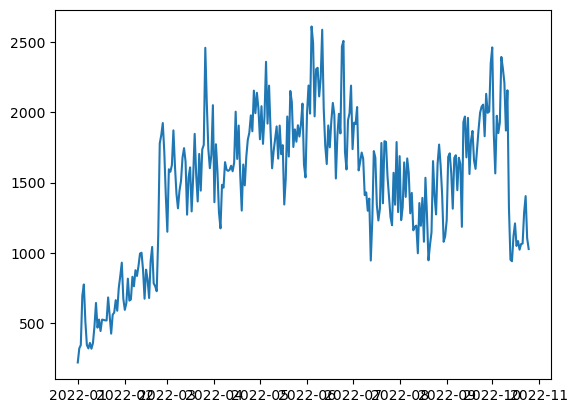

In [6]:
plt.plot(revenue_date_data)

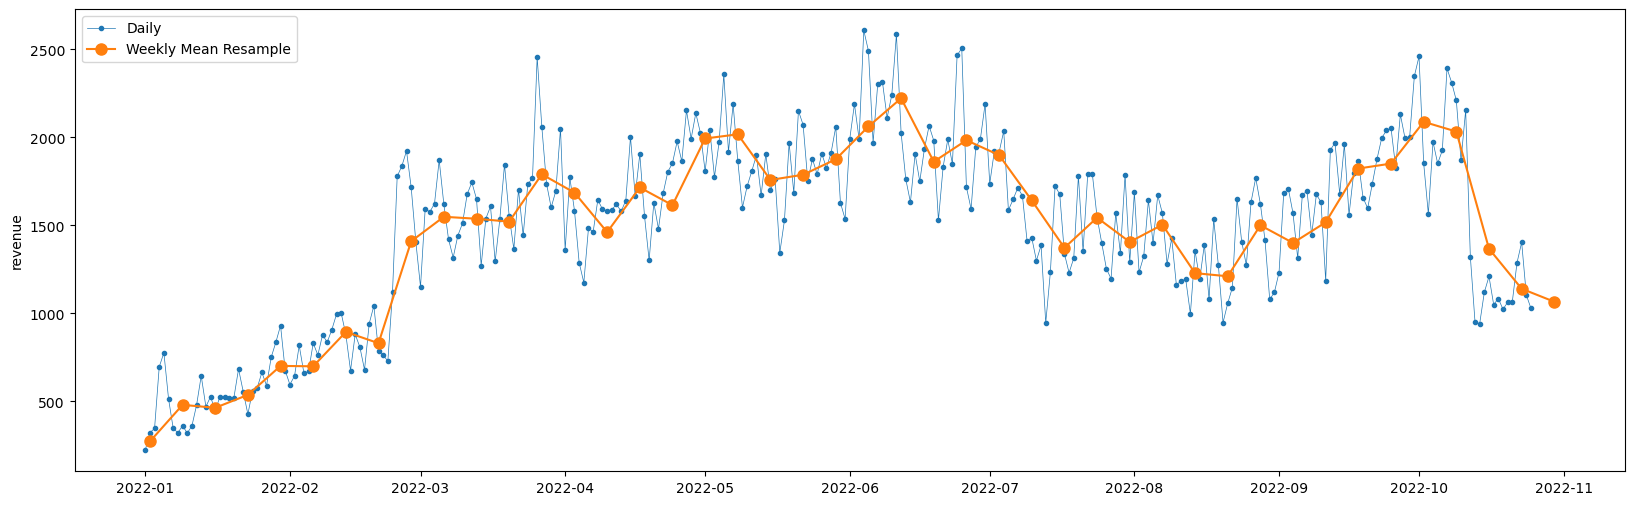

In [7]:
import warnings
import matplotlib.pyplot as plt
y = revenue_date_data['revenue']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(y.resample('W').mean(),marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('revenue')
ax.legend()

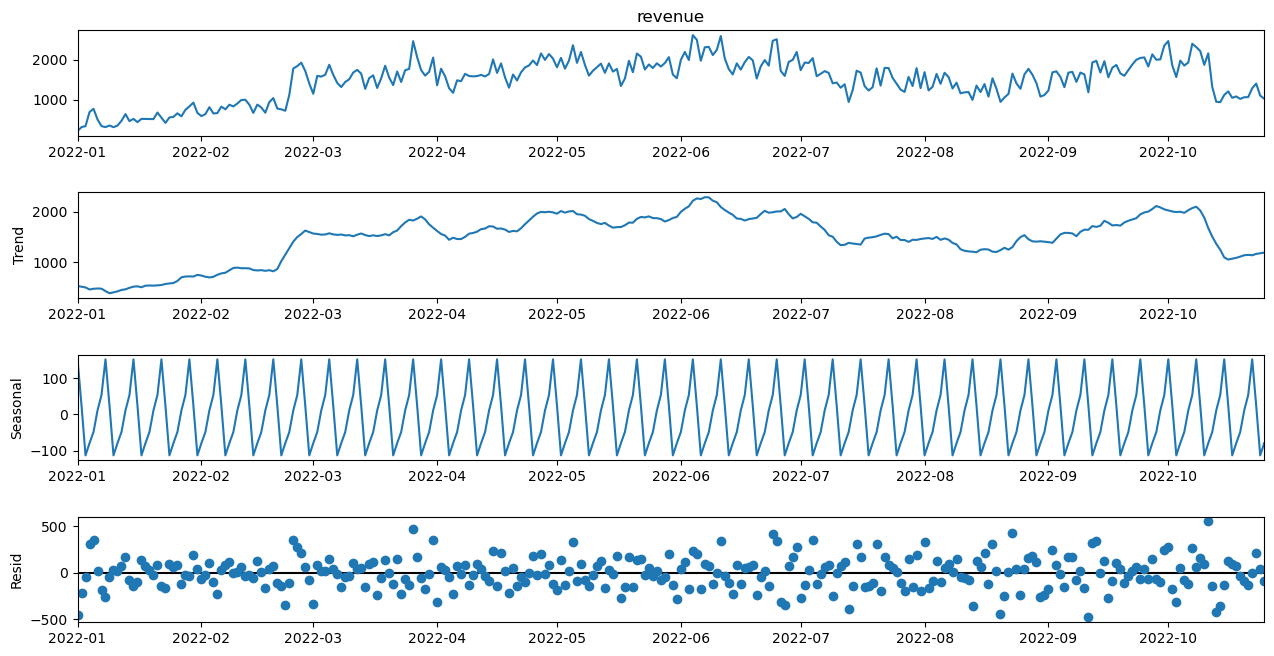

In [8]:
import statsmodels.api as sm

def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose(y)

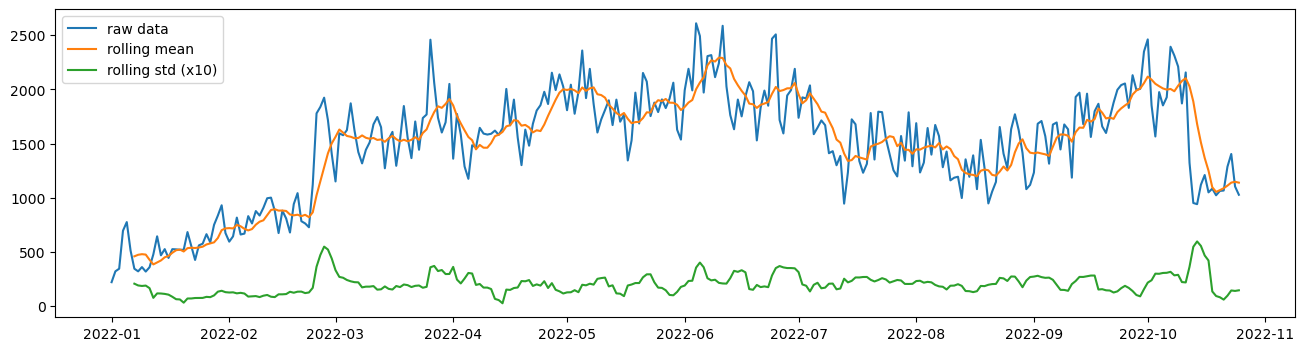

In [9]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=7).mean() 
    rolstd = pd.Series(timeseries).rolling(window=7).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean')
    ax.plot(rolstd, label='rolling std (x10)')
    ax.legend()

pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [10]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -2.354
P-value = 0.155
Critical values :
	1%: -3.4530232710482367 - The data is not stationary with 99% confidence
	5%: -2.871523926671883 - The data is not stationary with 95% confidence
	10%: -2.5720897694878424 - The data is not stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -2.704
P-value = 0.073
Critical values :
	1%: -3.4578942529658563 - The data is not stationary with 99% confidence
	5%: -2.8736593200231484 - The data is not stationary with 95% confidence
	10%: -2.573228767361111 - The data is  stationary with 90% confidence


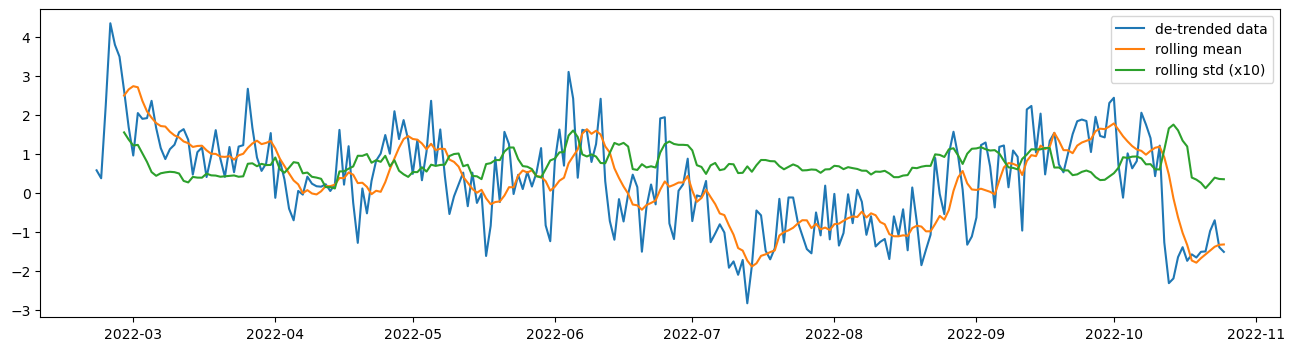

In [11]:
# Detrending
y_detrend =  (y - y.rolling(window=52).mean())/y.rolling(window=52).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

In [12]:
y_to_train = y[:'2022-09-30'] # dataset to train
y_to_val = y['2022-10-25':] # last X months for test  
predict_date = len(y) - len(y[:'2022-10-25']) # the number of data points for the test set

In [13]:
import itertools
def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    mini = float('+inf')
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

sarima_grid_search(y,52)

C:\Users\Peter Nguyen\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Peter Nguyen\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Peter Nguyen\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Peter Nguyen\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Peter Nguyen\AppData\Roaming\Python\Python39\site-packages\statsmodels\

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:2712.8500854795457


In [16]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    import datetime as dt
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()

    ### CODE BREAKS HERE DUE TO TYPE ERROR BUT IS NOT NECESSARY FOR MODEL TO FINISH RUNNING.  FIX IN MLV4.1
    # ===============================================================================================================================================
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    # pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    # #pred=pred.dt.date
    # pred_ci = pred.conf_int()
    # y_forecasted = pred.predicted_mean
    # mse = ((y_forecasted - y_to_test) ** 2).mean()
    # print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    # ax = y.plot(label='observed')
    # y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    # ax.fill_between(pred_ci.index,
    #                 pred_ci.iloc[:, 0],
    #                 pred_ci.iloc[:, 1], color='k', alpha=.2)

    # ax.set_xlabel('Date')
    # ax.set_ylabel('Sessions')
    # plt.legend()
    # plt.show()

    # # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # # In this case, we only use information from the time series up to a certain point, 
    # # and after that, forecasts are generated using values from previous forecasted time points.
    # pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    # #pred_dynamic = pred_dynamic.dt.date
    # pred_dynamic_ci = pred_dynamic.conf_int()
    # y_forecasted_dynamic = pred_dynamic.predicted_mean
    # mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    # print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    # ax = y.plot(label='observed')
    # y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    # ax.fill_between(pred_dynamic_ci.index,
    #                 pred_dynamic_ci.iloc[:, 0],
    #                 pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    # ax.set_xlabel('Date')
    # ax.set_ylabel('Sessions')

    # plt.legend()
    # plt.show()
    # ===============================================================================================================================================
    return (results)

C:\Users\Peter Nguyen\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Peter Nguyen\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3598      0.118      3.047      0.002       0.128       0.591
ma.L1         -0.7818      0.088     -8.863      0.000      -0.955      -0.609
ar.S.L52      -0.2376      0.111     -2.146      0.032      -0.455      -0.021
ma.S.L52      -0.7365      0.201     -3.660      0.000      -1.131      -0.342
sigma2      7.383e+04   1.08e+04      6.862      0.000    5.27e+04    9.49e+04


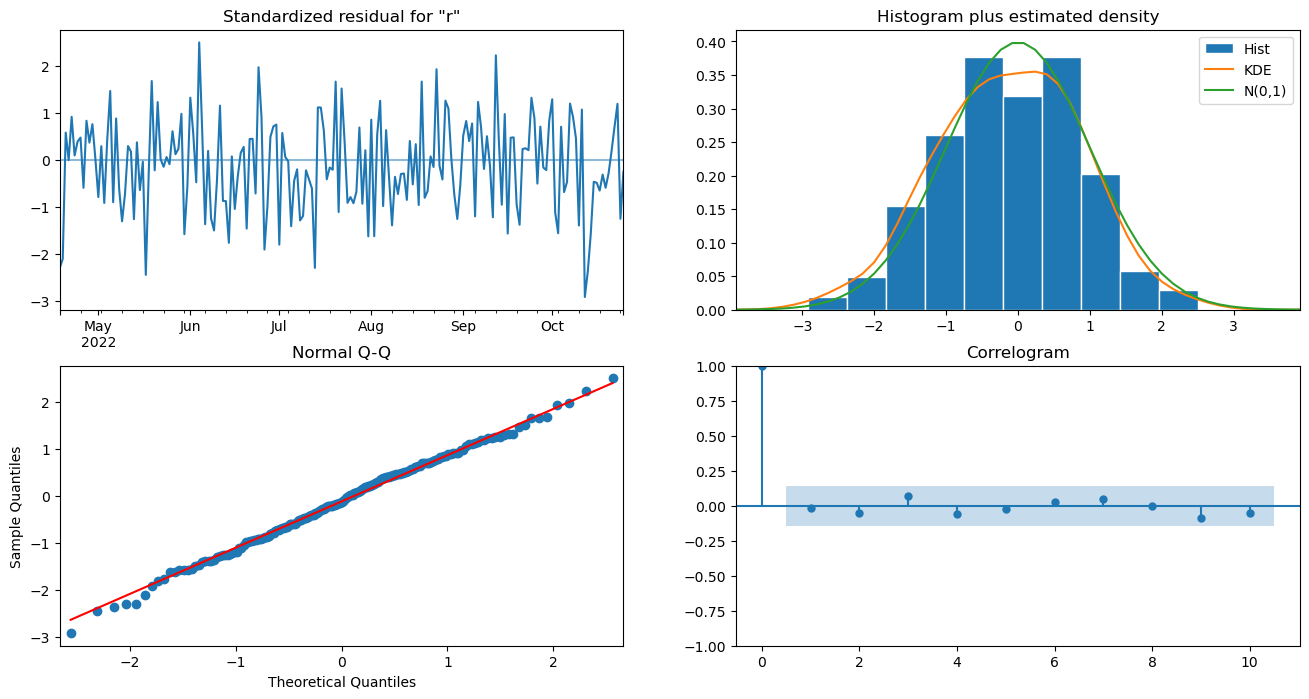

In [17]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 1, 52),7,'2022-10-25',y_to_val)

In [18]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()
    print(pred_ci)
    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

            lower revenue  upper revenue
2022-10-26   417.03210102  1498.10324704
2022-10-27   596.69795242  1846.35530911
2022-10-28   518.28284252  1850.96277643
2022-10-29   365.33044904  1757.86063263
2022-10-30   248.15320550  1692.24574079
2022-10-31   336.28946223  1828.19164290
2022-11-01   458.88969804  1996.42496812
2022-11-02   242.10417236  1823.70918592
2022-11-03   360.60621224  1984.99464967
2022-11-04   433.15088233  2099.18796785
2022-11-05   408.06781527  2114.71719760
2022-11-06   329.39477086  2075.68783213
2022-11-07   340.49940903  2125.50400611
2022-11-08   290.42560654  2113.20048634
2022-11-09   319.05967222  2178.53656312
2022-11-10   314.10155285  2208.22434732
2022-11-11   565.67170718  2494.94550316
2022-11-12   352.93107632  2316.63777777
2022-11-13   458.86635776  2456.41077139
2022-11-14   393.75147714  2424.60243784
2022-11-15   191.54900298  2255.19694833
2022-11-16   204.13652015  2300.08638573
2022-11-17   174.56059268  2302.33286832
2022-11-18   313

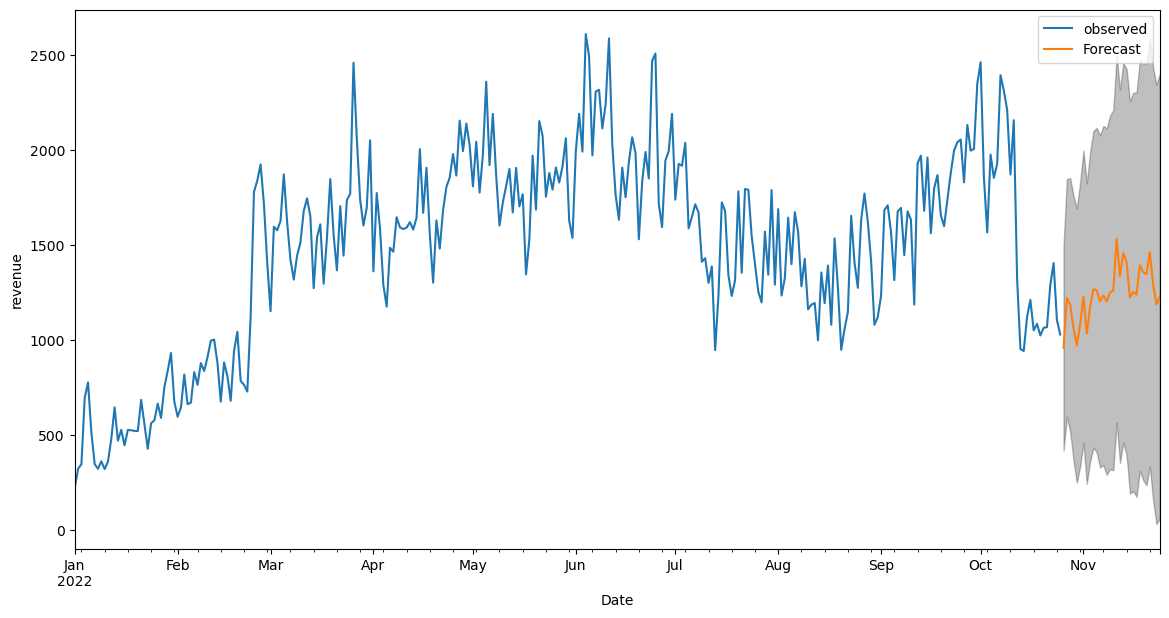

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-10-26,957.56767403,417.03210102,1498.10324704
1,2022-10-27,1221.52663077,596.69795242,1846.35530911
2,2022-10-28,1184.62280947,518.28284252,1850.96277643
3,2022-10-29,1061.59554084,365.33044904,1757.86063263
4,2022-10-30,970.19947314,248.15320550,1692.24574079


In [20]:
final_table = forecast(model,30,y)
final_table.head()